## Fermi Raw Data

Visualizing the galactic center excess data from Fermi-LAT

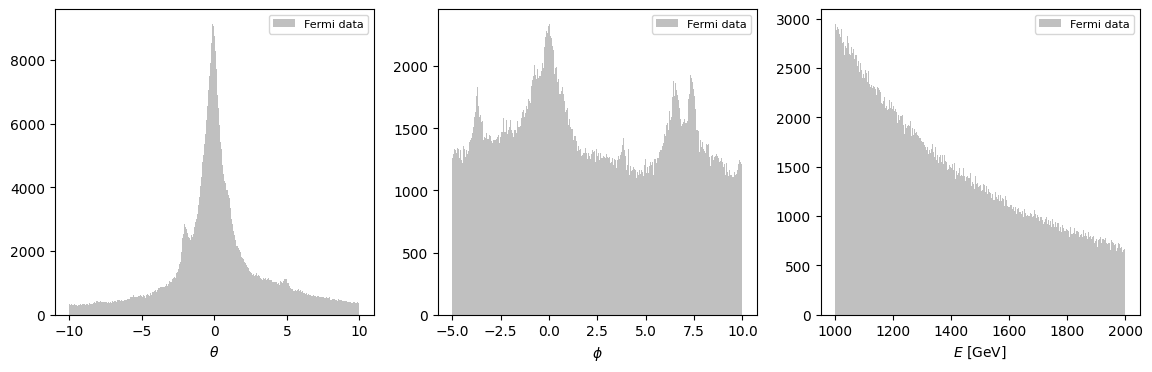

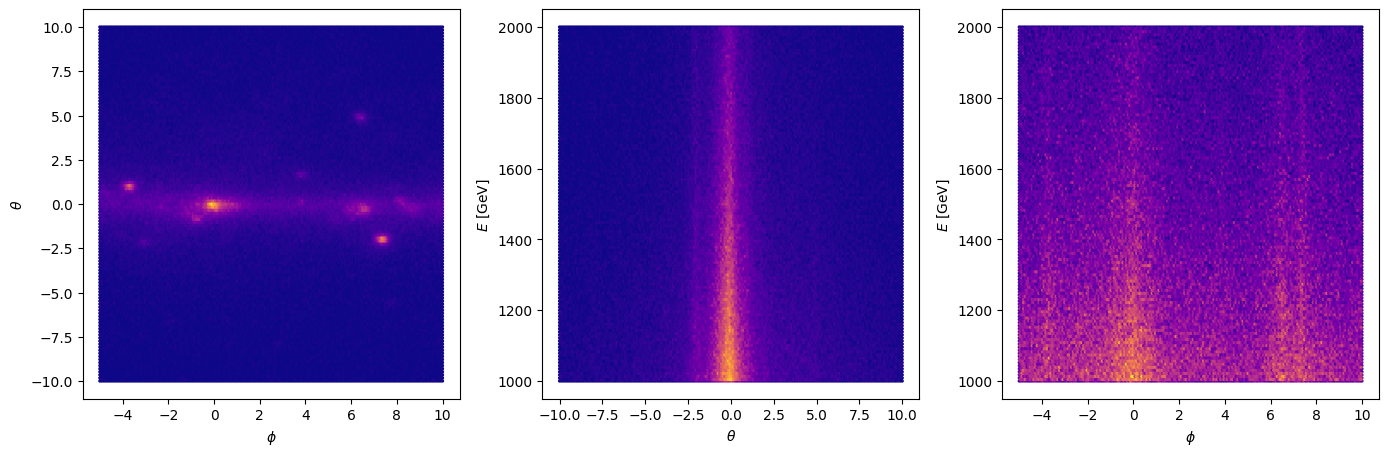

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from DynGenModels.datamodules.fermi.datasets import FermiDataset
from DynGenModels.datamodules.fermi.configs import FermiGCE_Configs 

configs = FermiGCE_Configs(cuts = {'theta': [-10., 10.], 'phi': [-5., 10.], 'energy': [1000, 2000]})
fermi = FermiDataset(configs)

# #...plot data:

from utils import results_plots, results_2D_plots
results_plots(fermi.target, bins=300)
results_2D_plots(fermi.target, gridsize=200)

# Pretrained Normalizing flows

Load a previsoiusly trained model that was stored somewhere in a directory. The directory must contain the follwing files:
- `config.json` file with all the parameters used during the training.
- `best_epoch_model.pth` model file corresponding the trained model that had the lowest validation loss.
- `last_epoch_model.pth` model file corresponding the last epoch trained model.


### 1. Load pre-trained MAF model
 

In [8]:
#...provide the directory of the trained model and load the configuration file in it:

from DynGenModels.configs.fermi_configs import FermiGCE_MAF_RQS_NormFlow as Configs

model_workdir = '../../results/FermiGCE.NormFlow.MAF_RQS.2023.10.19_15h19'
configs = Configs().load(model_workdir + '/config.json')
configs.DEVICE = 'cuda:1'   # select device
configs.workdir = model_workdir

#...be sure to use the same dataset, dataloader and model that was used for training the pre-trained model:

from DynGenModels.datamodules.fermi.datasets import FermiDataset 
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader 
from DynGenModels.models.nflow_nets import MAFPiecewiseRQS
from DynGenModels.dynamics.nf.normflows import NormalizingFlow
from DynGenModels.trainer.trainer import DynGenModelTrainer

fermi = FermiDataset(configs)
pretrained_maf = DynGenModelTrainer(dynamics = NormalizingFlow(configs),
                                    model = MAFPiecewiseRQS(configs),
                                    dataloader = FermiDataLoader(fermi, configs), 
                                    configs = configs)

#...load the pre-trained model:

pretrained_maf.load()

+---------------------+-------------------------------------------------+
| Parameters          | Values                                          |
+---------------------+-------------------------------------------------+
| DATA                | FermiGCE                                        |
| dataset             | ../../data/fermi/fermi_data_galactic_coord.npy  |
| features            | ['theta', 'phi', 'energy']                      |
| dim_input           | 3                                               |
| preprocess          | ['normalize', 'logit_transform', 'standardize'] |
| cuts                | theta: [-10.0, 10.0]                            |
|                     | phi: [-5.0, 10.0]                               |
|                     | energy: [1000, 2000]                            |
| DEVICE              | cuda:3                                          |
| optimizer           | Adam                                            |
| lr                  | 0.0001        

### 2. Load pre-trained Coupling layers model


In [9]:
#...provide the directory of the trained model and load the configuration file in it:

from DynGenModels.configs.fermi_configs import FermiGCE_Couplings_RQS_NormFlow as Configs

model_workdir = '../../results/FermiGCE.NormFlow.Couplings_RQS.2023.10.19_15h20'
configs = Configs().load(model_workdir + '/config.json')
configs.DEVICE = 'cuda:1'   # optional, this changes the device 
configs.workdir = model_workdir

#...be sure to use the same dataset, dataloader and model that was used for training the pre-trained model:

from DynGenModels.datamodules.fermi.datasets import FermiDataset 
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader 
from DynGenModels.models.nflow_nets import CouplingsPiecewiseRQS
from DynGenModels.dynamics.nf.normflows import NormalizingFlow
from DynGenModels.trainer.trainer import DynGenModelTrainer

fermi = FermiDataset(configs)
pretrained_coupl = DynGenModelTrainer(dynamics = NormalizingFlow(configs),
                                    model = CouplingsPiecewiseRQS(configs),
                                    dataloader = FermiDataLoader(fermi, configs), 
                                    configs = configs)

#...load the pre-trained model:

pretrained_coupl.load()

+---------------------+-------------------------------------------------+
| Parameters          | Values                                          |
+---------------------+-------------------------------------------------+
| DATA                | FermiGCE                                        |
| dataset             | ../../data/fermi/fermi_data_galactic_coord.npy  |
| features            | ['theta', 'phi', 'energy']                      |
| dim_input           | 3                                               |
| preprocess          | ['normalize', 'logit_transform', 'standardize'] |
| cuts                | theta: [-10.0, 10.0]                            |
|                     | phi: [-5.0, 10.0]                               |
|                     | energy: [1000, 2000]                            |
| DEVICE              | cuda:2                                          |
| optimizer           | Adam                                            |
| lr                  | 0.0001        

### 2. sample from loaded models

In [10]:
#...up-sample 500k data points from the loaded model

from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData

pipeline_maf = NormFlowPipeline(trained_model=pretrained_maf, 
                            configs=configs, 
                            postprocessor=PostProcessFermiData,
                            num_gen_samples=fermi.target.shape[0],
                            best_epoch_model=True)

pipeline_coupl = NormFlowPipeline(trained_model=pretrained_coupl, 
                            configs=configs, 
                            postprocessor=PostProcessFermiData,
                            num_gen_samples=fermi.target.shape[0],
                            best_epoch_model=True)
# the new samples are called with the 'target' attribute:

print(pipeline_maf.target.shape)
print(pipeline_coupl.target.shape)


INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']
INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']
torch.Size([436735, 3])
torch.Size([436735, 3])


### Plot results:

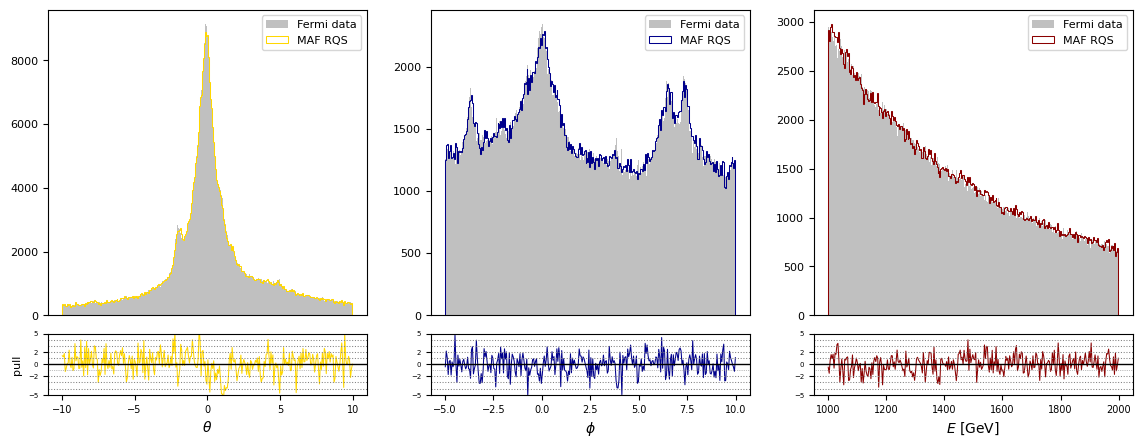

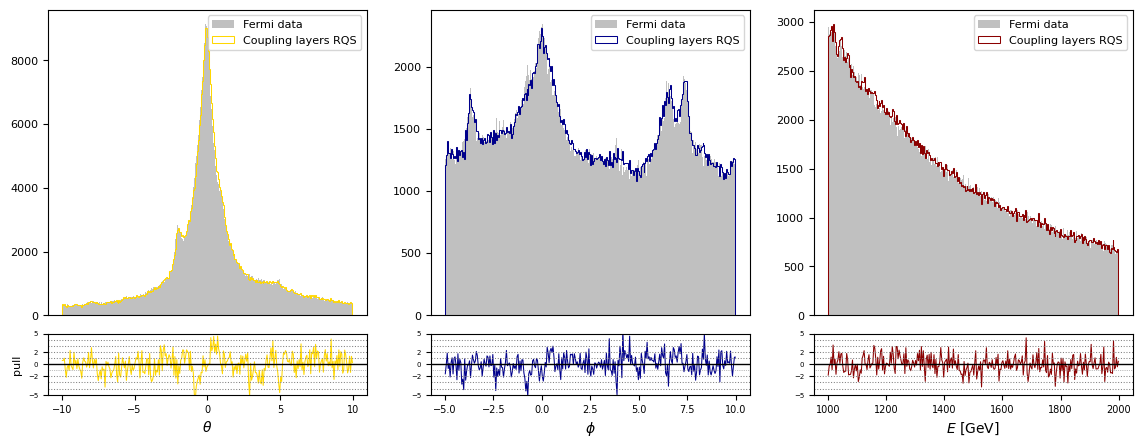

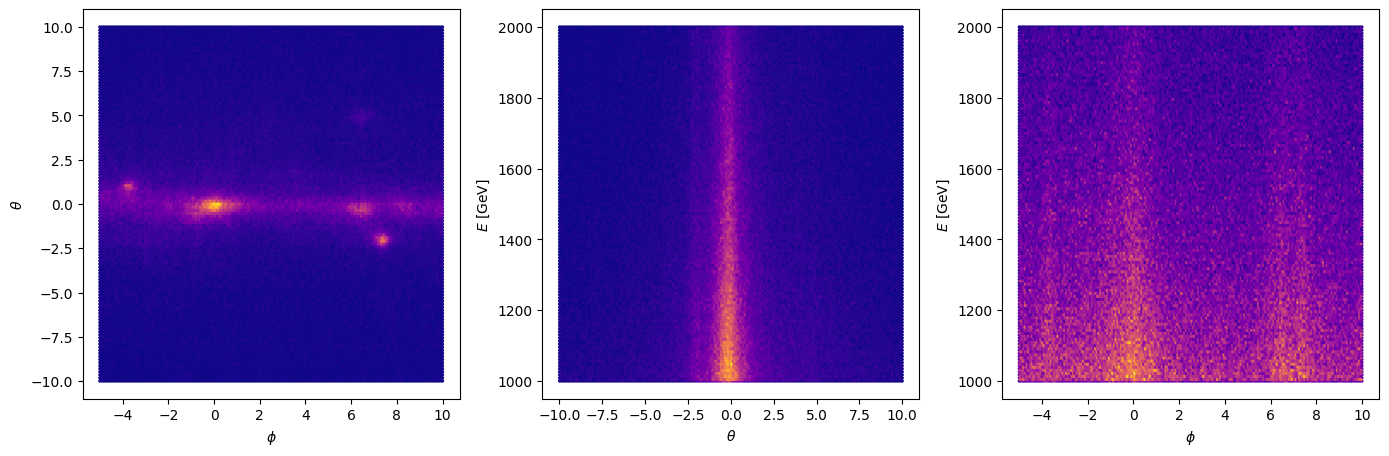

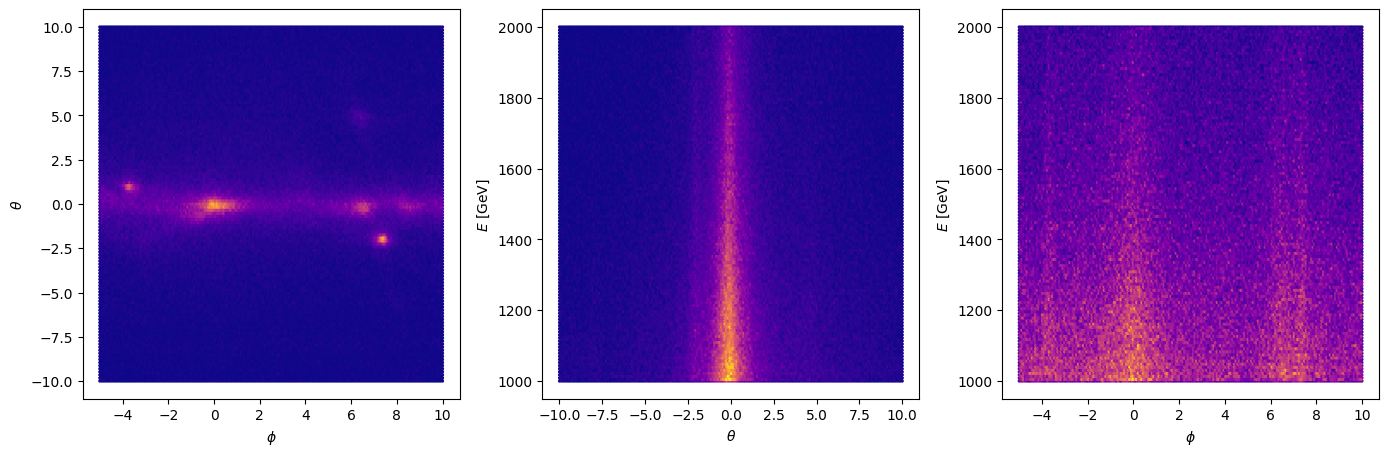

In [12]:
from utils import results_plots, results_2D_plots

results_plots(data=fermi.target, 
              generated=pipeline_maf.target, 
              comparator='pull',
              model = 'MAF RQS', 
              save_path=configs.workdir + '/fermi_features.pdf', 
              bins=300, 
              features=[r'$\theta$', r'$\phi$', r'$E$ [GeV]'])

results_plots(data=fermi.target, 
              generated=pipeline_coupl.target, 
              comparator='pull',
              model = 'Coupling layers RQS', 
              save_path=configs.workdir + '/fermi_features.pdf', 
              bins=300, 
              features=[r'$\theta$', r'$\phi$', r'$E$ [GeV]'])

results_2D_plots(pipeline_maf.target, gridsize=200)
results_2D_plots(pipeline_coupl.target, gridsize=200)